In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, LinearConstraint
from IPython.core.interactiveshell import InteractiveShell
from common.calculate_volatility import calculate_variance

import datetime as dt

InteractiveShell.ast_node_interactivity = "all"

In [134]:
# data 기초 전처리
data = pd.read_csv('../data/GSPC.csv')
data = data.set_index('Date')

# 인덱스를 datetime으로 변경
data.index = pd.to_datetime(data.index)

# test 셋과 train 셋으로 나누기
split_date= dt.datetime(2011,12,5)
train_data = data[data.index<split_date]
test_data = data[data.index>=split_date]

# log 수익률 column 추가
train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
train_data_return = train_data['log_price_return'].dropna()

test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)
test_data_return = test_data['log_price_return'].dropna()


/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_48415/536290991.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_48415/536290991.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)


In [135]:
# dataset 만들기
# train
train_data_set = pd.DataFrame()
var = calculate_variance(train_data_return)
train_data_set['rv'] = np.sqrt(var)
train_data_set['log_return'] = train_data_return
# test
test_data_set = pd.DataFrame()
var = calculate_variance(test_data_return)
test_data_set['rv'] = np.sqrt(var)
test_data_set['log_return'] = test_data_return


In [136]:
# scaling 
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

train_data_minmax = scaler_minmax.fit_transform(train_data_set)
test_data_minmax = scaler_minmax.transform(test_data_set)

# 정규화가 완료된 데이터를 데이터 프레임으로 다시 변경
train_data_df = pd.DataFrame(train_data_minmax, index=train_data_set.index,columns=train_data_set.columns)
test_data_df = pd.DataFrame(test_data_minmax, index=test_data_set.index,columns=test_data_set.columns)

In [137]:
from garch.garch_mle2 import garch_mle
# from garch.garch import garch_mle

bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
#조건 alpha + beta < 1
LC = LinearConstraint([[0,1,1]], lb=0, ub=1)

# DE 알고리즘을 사용한 파라미터 추정
result = differential_evolution(garch_mle, bounds=bounds, args=(train_data_set['log_return'],train_data_set['rv']), constraints=LC,
                                strategy='best1bin', maxiter=30, popsize=20, tol=1e-3, mutation=(0.3, 1),
                                recombination=0.7)

print("Optimized GARCH(1,1) Parameters:")
print(result.x)

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimized GARCH(1,1) Parameters:
[3.85406727e-05 1.25894385e-09 8.19858191e-01]


In [139]:
garch_mle([0.5,0.5,0.5],train_data_set['log_return'],train_data_set['rv'])

1712.4005867703108

In [140]:
omega,alpha,beta = result.x
forecasts = np.zeros(len(test_data_set))
for t in range(1, len(test_data_set)):
    forecasts[t] = omega + alpha*test_data_set['log_return'][t-1]**2 + beta*test_data_set['rv'][t-1]**2

In [141]:
forecasts

array([0.00000000e+00, 1.97265271e-04, 2.09544456e-04, 2.30237145e-04,
       1.57084633e-04, 1.12812628e-04, 9.86290138e-05, 2.27776907e-04,
       2.07039555e-04, 2.16431059e-04, 2.28005855e-04, 2.05166962e-04,
       8.93923497e-05, 1.07369052e-04, 9.92911602e-05, 1.24688759e-04,
       1.24693523e-04, 1.00257515e-04, 8.27168728e-05, 8.05210258e-05,
       5.46905903e-05, 5.47005124e-05, 5.41769476e-05, 5.71532113e-05,
       5.83789813e-05, 6.55557512e-05, 6.95196996e-05, 6.86999837e-05,
       6.47020979e-05, 6.28122593e-05, 5.50481280e-05, 5.65285207e-05,
       5.68717838e-05, 5.78810500e-05, 5.77425783e-05, 5.83697568e-05,
       5.31061473e-05, 8.71631792e-05, 8.61469744e-05, 8.67826777e-05,
       7.46738054e-05, 7.48331478e-05, 4.81890262e-05, 5.56904498e-05,
       5.51653681e-05, 5.91792673e-05, 7.85393077e-05, 7.16122841e-05,
       6.41663108e-05, 6.58568842e-05, 6.40592082e-05, 4.48011430e-05,
       4.41990075e-05, 4.59550396e-05, 4.78164651e-05, 5.10166831e-05,
      

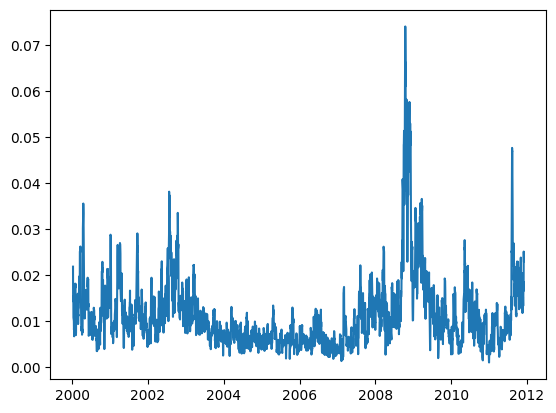

In [142]:
plt.plot(train_data_set['rv'])

MinMaxScaler()

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


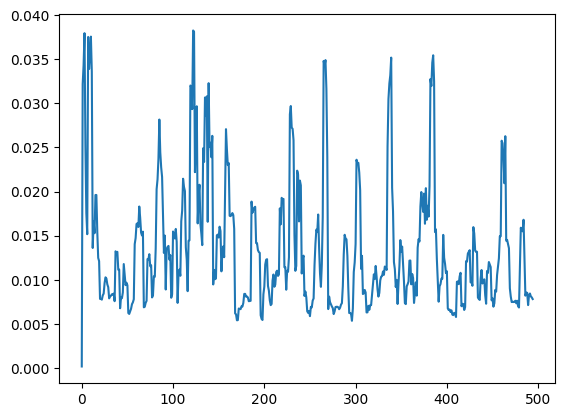

In [143]:
rv_train = pd.DataFrame(train_data_set['rv'])
scaler_garch = MinMaxScaler()
scaler_garch.fit(rv_train)

forecasts = np.sqrt(forecasts)
df = scaler_garch.transform(forecasts.reshape(-1,1))
plt.plot(df**2)

<Figure size 1000x800 with 0 Axes>

([<matplotlib.axis.YTick at 0x7ff32cb195b0>,
 [Text(0, 0.0, '0.00'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.03, '0.03'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.06, '0.06'),
  Text(0, 0.07, '0.07')])

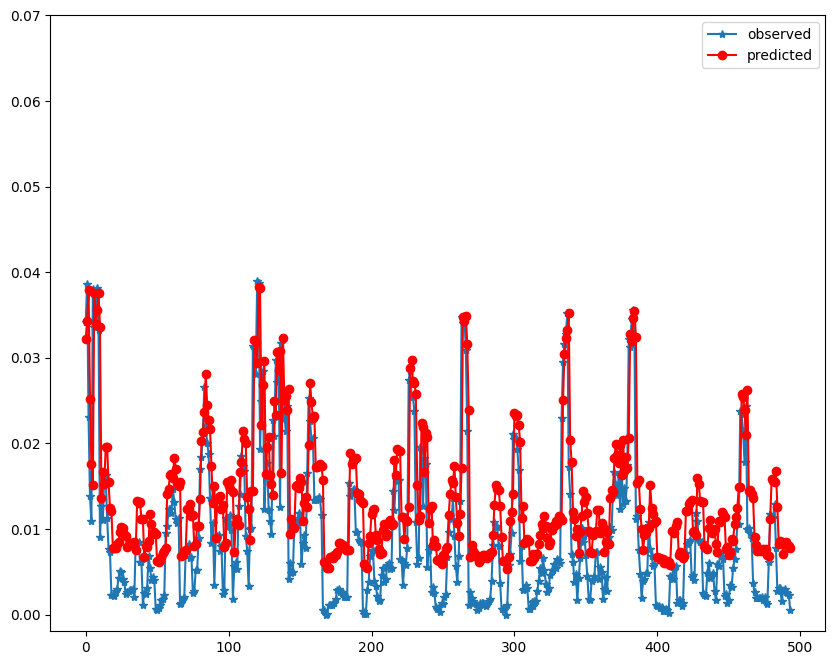

In [149]:
plt.figure(figsize=(10,8))
y = test_data_df['rv'].values
y_hat = df
plt.plot(y[1:]**2,marker='*', label='observed')
plt.plot(y_hat[1:]**2,marker='o', label = "predicted", color='red')

plt.yticks(np.arange(0,0.08,0.01))

plt.legend()


In [150]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y[1:],y_hat[1:],squared=False)

0.03657753073920813